# Importowanie potrzebnych bibliotek.

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from eli5 import show_weights
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from yellowbrick.classifier import ClassificationReport

%matplotlib inline
warnings.filterwarnings('ignore')

# Parametry

In [2]:
CV_N_REPEATS=5
BINS=10

# Wczytanie danych z pliku CSV do DataFrame i wyświetlenie danych

In [3]:
df = pd.read_csv('VLagun_Chem_Years3.csv')
df.head()

,SRP,DOP,PP,NH4N,NO3N,DON,PN,TN/TP,Fe,SiO4Si,DINtoDIP,Years
0,3.5,11.7,185.0,0.039,0.022,0.551,0.759,6.848152,0.0121,2.3112,17.428571,0
1,4.4,17.5,111.3,0.020,0.025,0.123,1.181,10.127628,0.0136,2.1157,10.227273,0
2,3.2,22.8,103.4,0.016,0.008,0.582,0.576,9.134467,0.0368,2.2641,7.500000,0
3,4.3,22.3,92.7,0.026,0.021,0.693,0.689,11.978206,0.0172,2.2623,10.930233,0
4,11.7,30.3,73.2,0.022,0.048,0.383,1.006,12.664931,0.0237,2.2164,5.982906,0


In [4]:
print('Shape of the dataset', df.shape)

Shape of the dataset (120, 12)


# Rozkład zmiennej docelowej

Text(0, 0.5, 'Years')

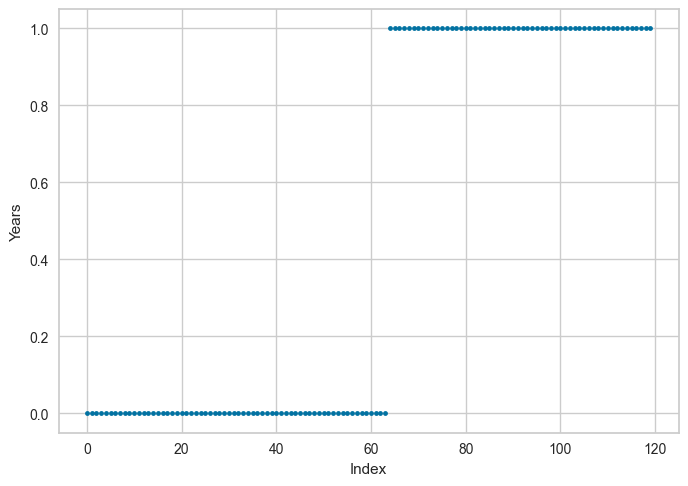

In [5]:
plt.figure()
plt.plot(df.Years, '.')
plt.xlabel('Index')
plt.ylabel('Years')

Text(0.5, 1.0, 'Seaborn countplot of Years rate within the dataset')

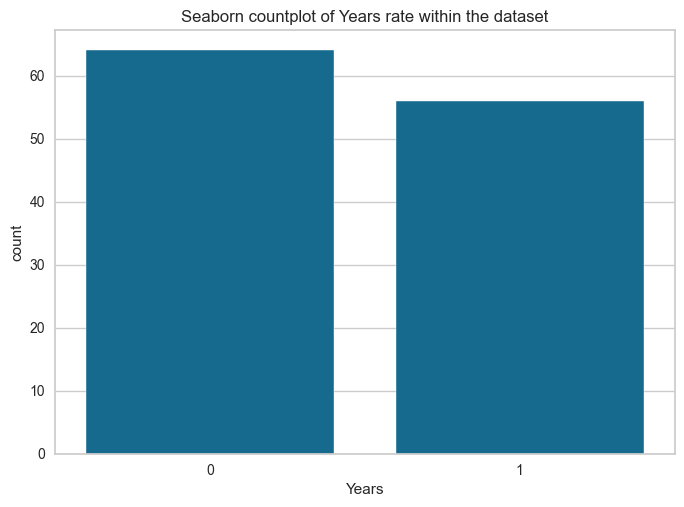

In [6]:
plt.figure()
ax = sns.countplot(data=df, x='Years')
ax.set_title('Seaborn countplot of Years rate within the dataset')

# Wykresy pudełkowe cech i zmiennej docelowej

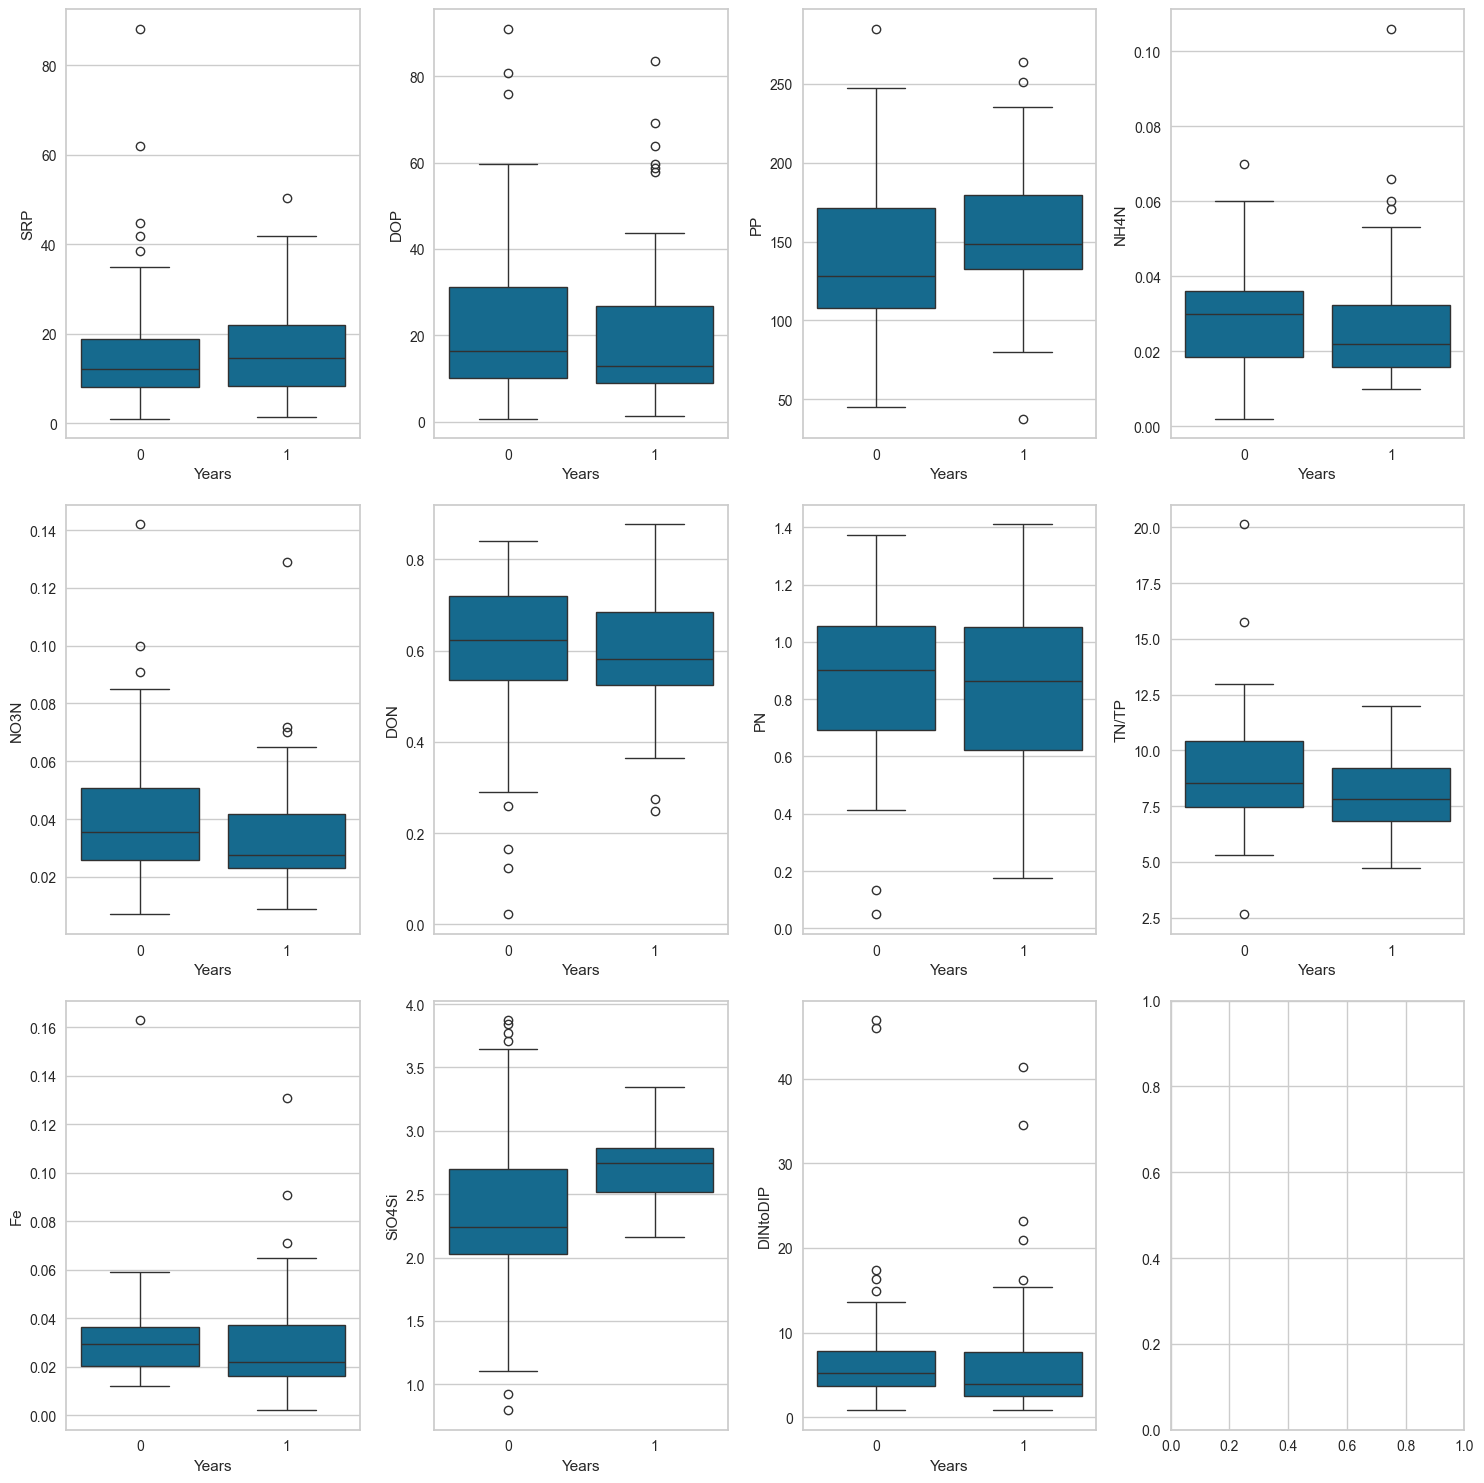

In [7]:
f, axes = plt.subplots(3, 4, figsize=(15, 15))
sns.set(style="white", palette="Set3", color_codes=True)
sns.boxplot(x="Years", y="SRP", data=df, orient='v', ax=axes[0,0])
sns.boxplot(x="Years", y="DOP", data=df, orient='v', ax=axes[0,1])
sns.boxplot(x="Years", y="PP", data=df, orient='v', ax=axes[0,2])
sns.boxplot(x="Years", y="NH4N", data=df, orient='v', ax=axes[0,3])
sns.boxplot(x="Years", y="NO3N", data=df, orient='v', ax=axes[1,0])
sns.boxplot(x="Years", y="DON", data=df, orient='v', ax=axes[1,1])
sns.boxplot(x="Years", y="PN", data=df, orient='v', ax=axes[1,2])
sns.boxplot(x="Years", y="TN/TP", data=df, orient='v', ax=axes[1,3])
sns.boxplot(x="Years", y="Fe", data=df, orient='v', ax=axes[2,0])
sns.boxplot(x="Years", y="SiO4Si", data=df, orient='v', ax=axes[2,1])
sns.boxplot(x="Years", y="DINtoDIP", data=df, orient='v', ax=axes[2,2])
f.subplots_adjust(left=0.08, right=0.98, top=0.9, bottom=0.05, hspace=0.4, wspace=0.3)
plt.tight_layout()

# Sprawdzenie czy są wartości brakujące

In [8]:
df_copy = df.copy(deep=True)
df_copy[['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP']] = df_copy[['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP']].replace(0, np.nan)

print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entries in each attribute:

SRP         0
DOP         0
PP          0
NH4N        0
NO3N        0
DON         0
PN          0
TN/TP       0
Fe          0
SiO4Si      0
DINtoDIP    0
Years       0
dtype: int64


# Nie ma wartości brakujących

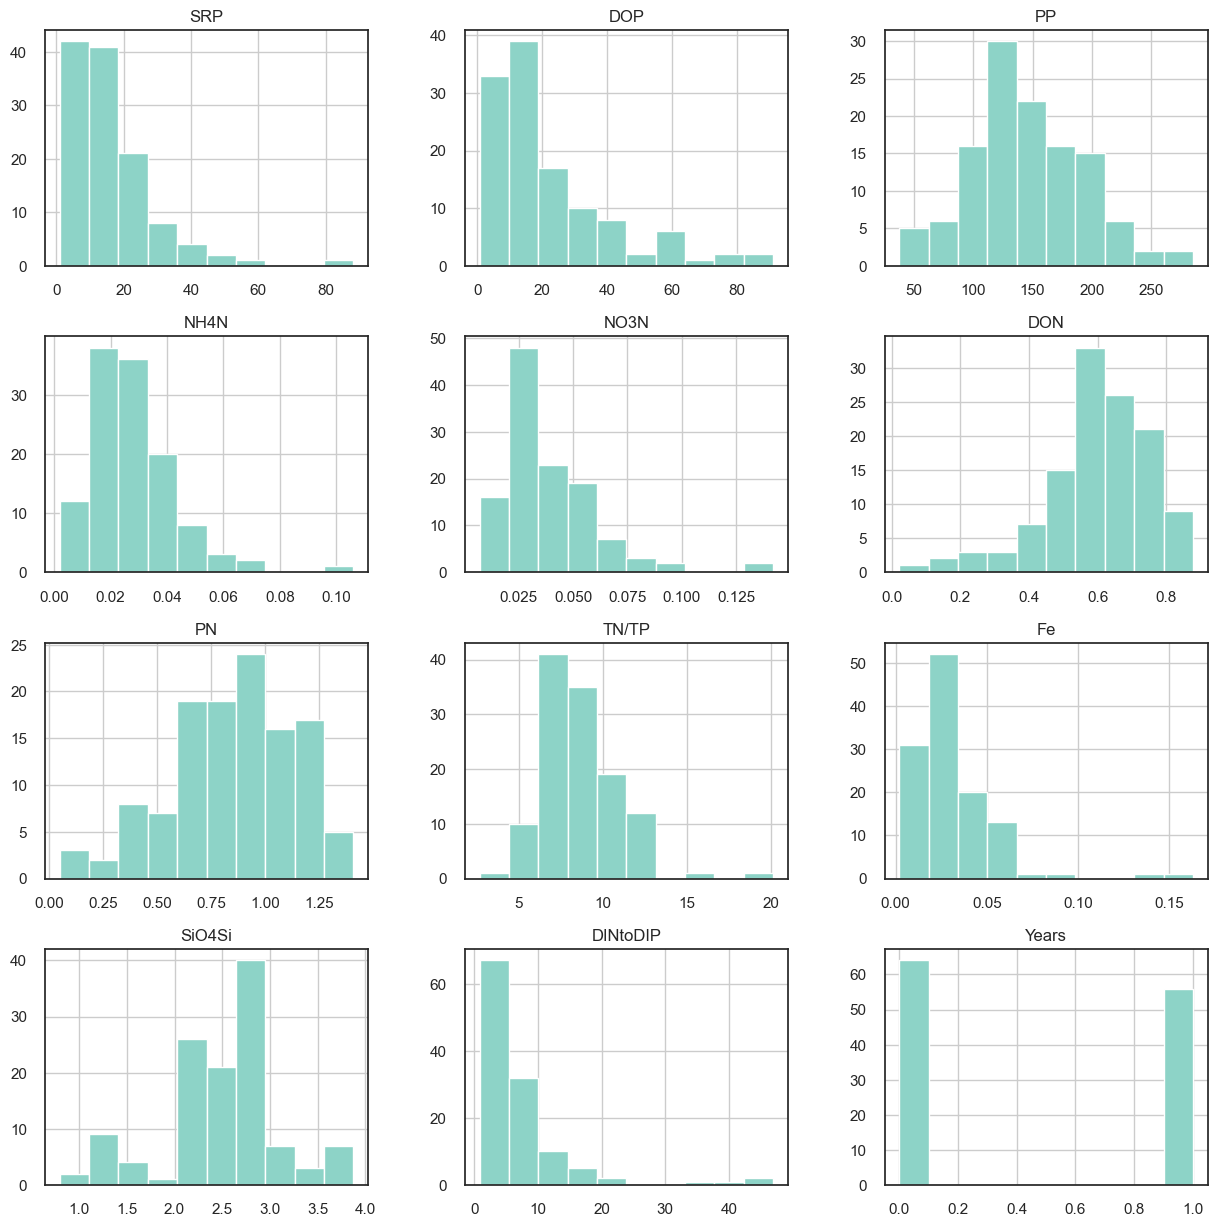

In [9]:
p = df.hist(figsize=(15,15))

# Mapy zależności cech

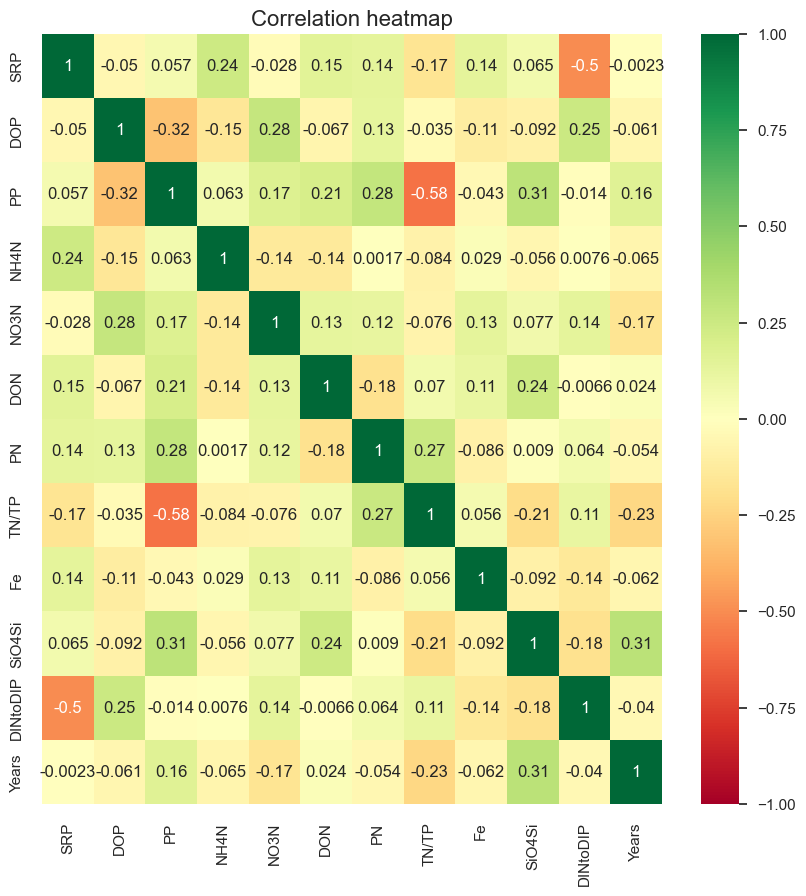

In [10]:
plt.figure(figsize=(10, 10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation heatmap", fontsize=16)
plt.show()

<Figure size 800x550 with 0 Axes>

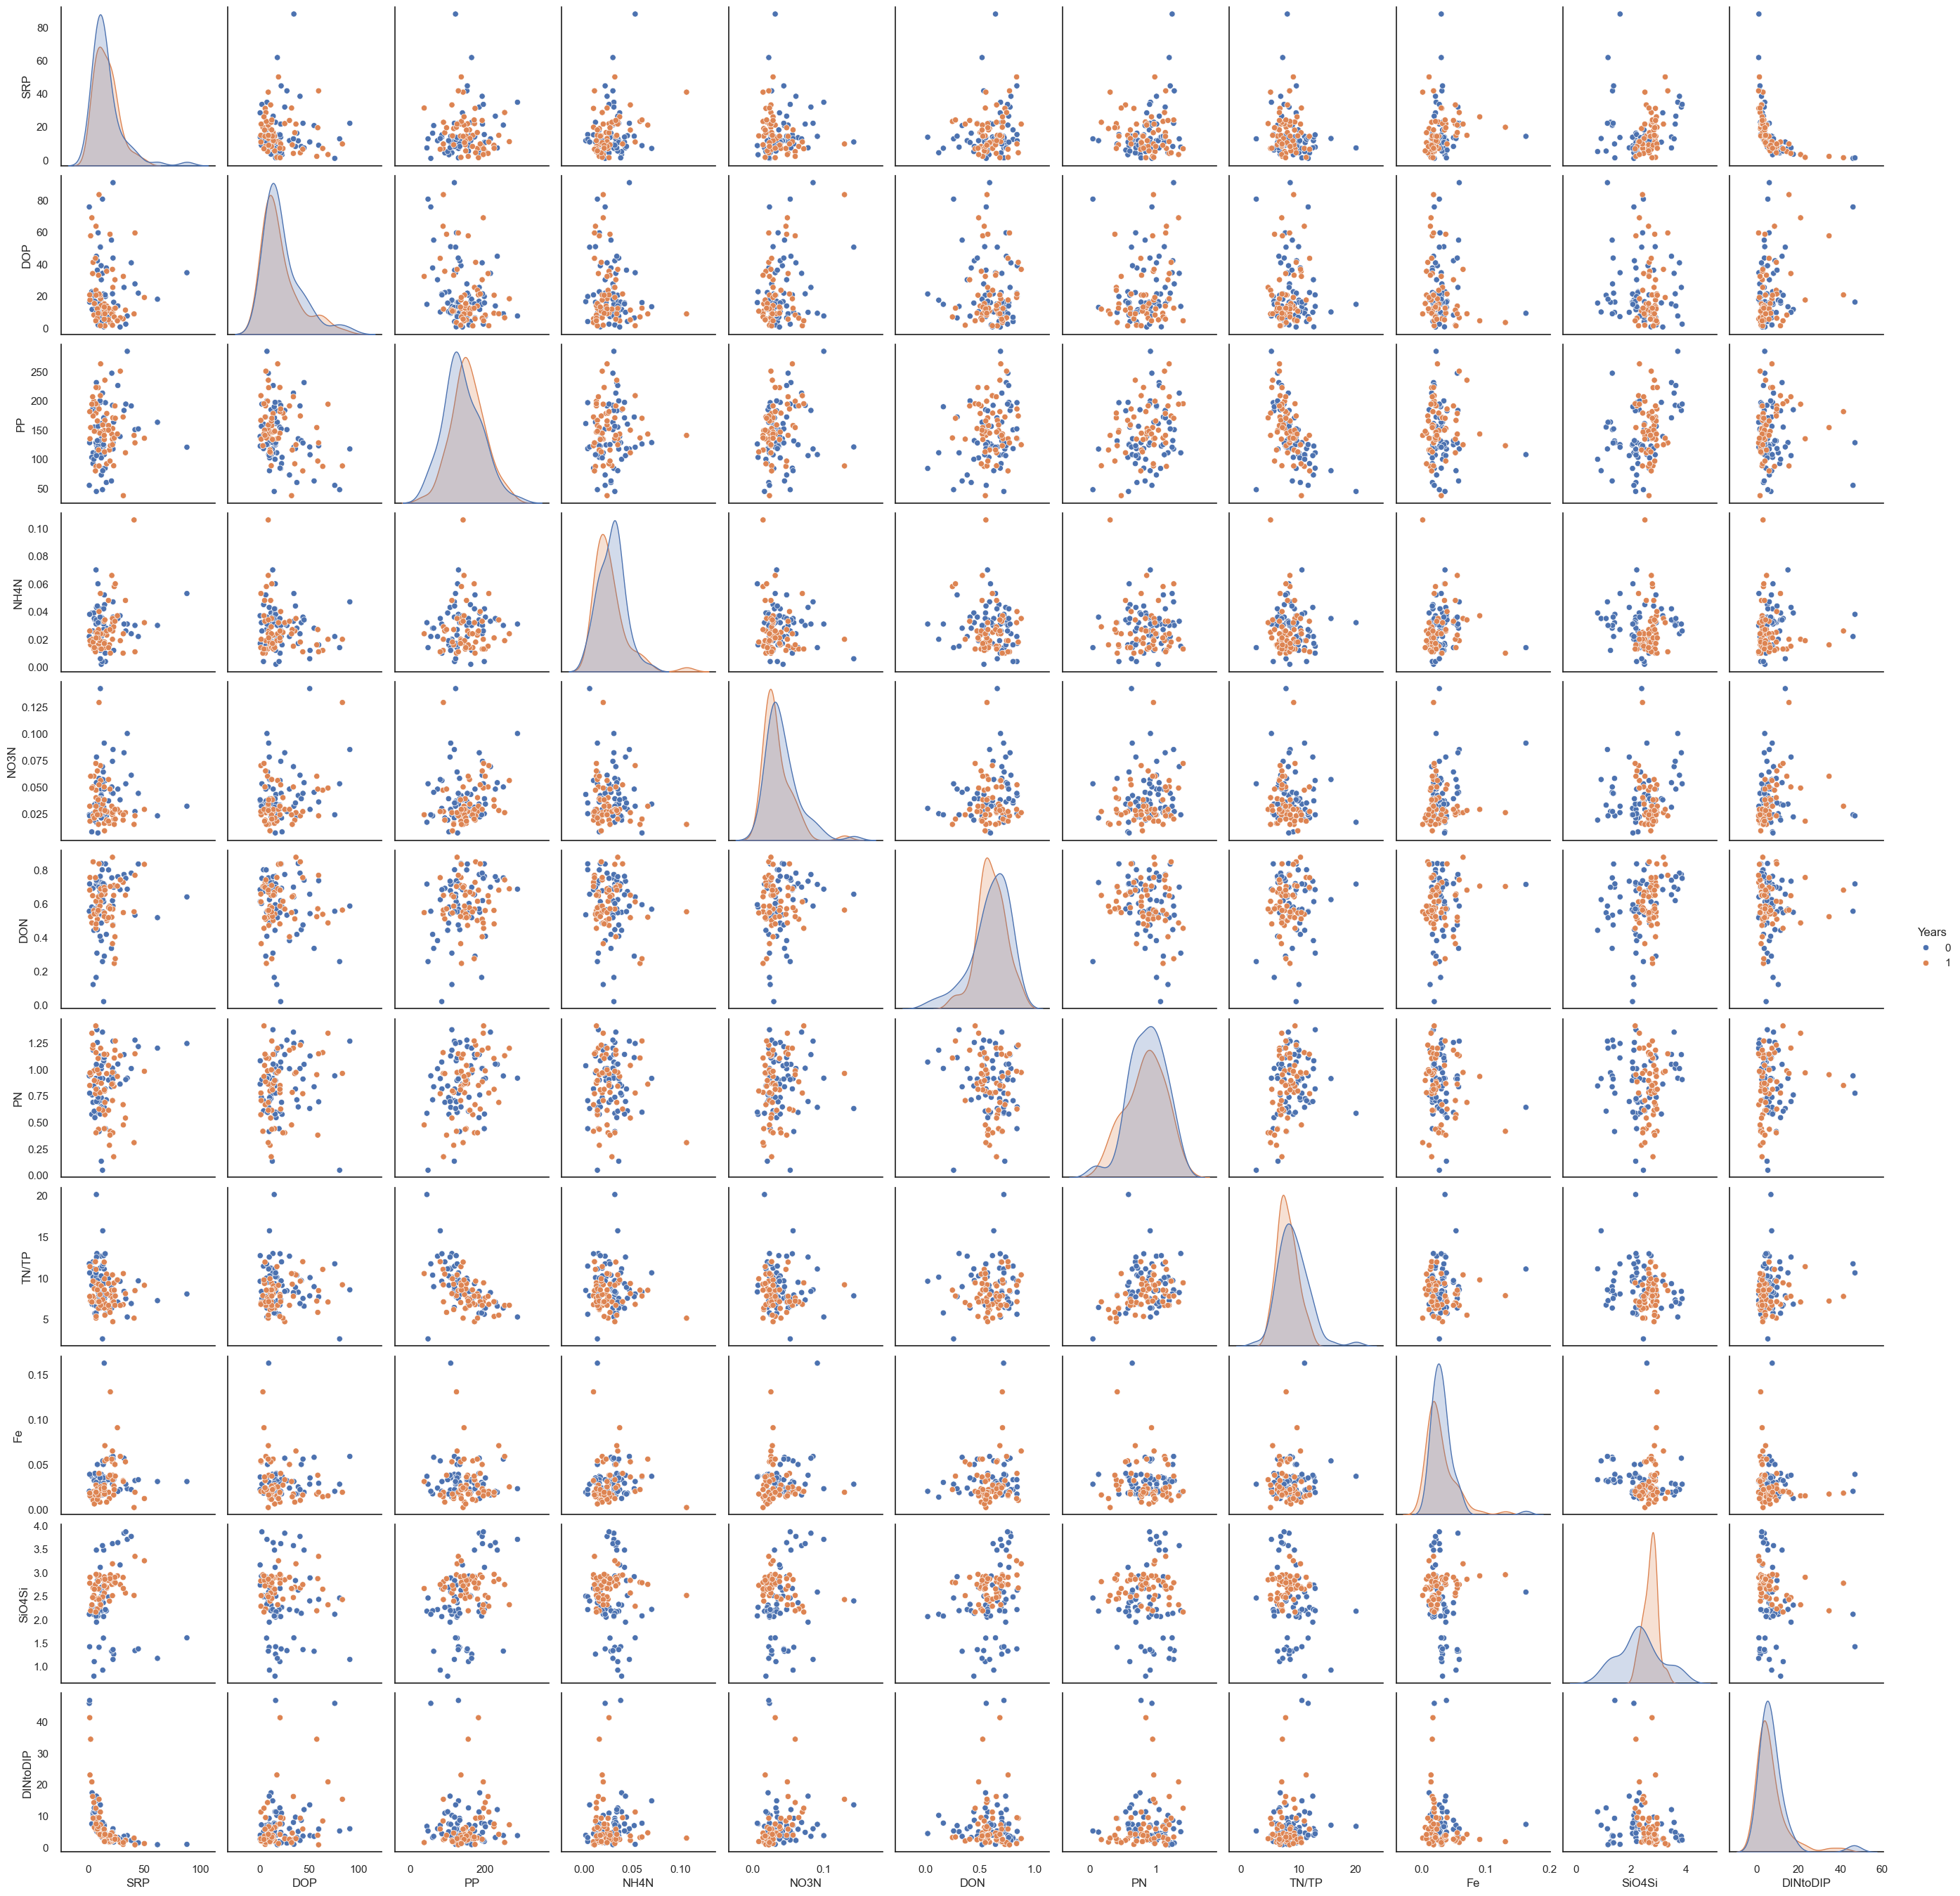

In [11]:
plt.figure()
sns.pairplot(df_copy, hue='Years', diag_kind='kde', palette='deep')

# PCA

In [12]:
X = df_copy.iloc[:, :11]
Y = df_copy.iloc[:, 11]
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=.90)
pca.fit(X)
print('Variance explained by the principal components (in decreasing order)', pca.explained_variance_ratio_)
X1 = pca.transform(X)
print('Shape of transformed X:', X1.shape)

Variance explained by the principal components (in decreasing order) [0.18895058 0.1495043  0.12268902 0.11774918 0.10197341 0.09548722
 0.07926256 0.06260638]
Shape of transformed X: (120, 8)


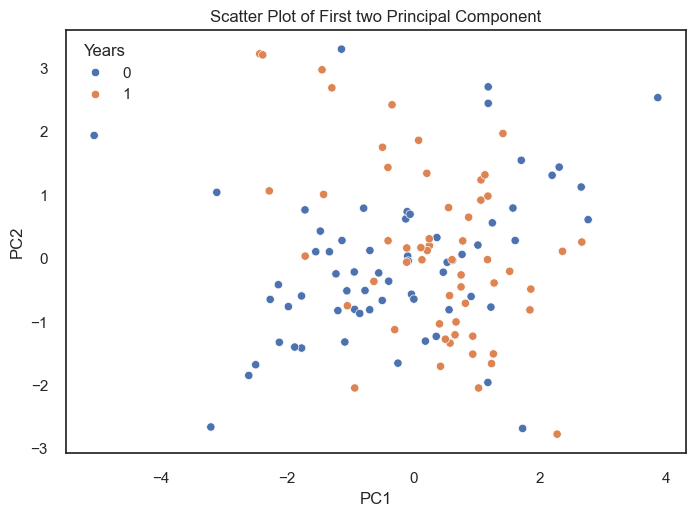

In [13]:
plt.figure()
sns.scatterplot(x=X1[:, 0], y=X1[:, 1], hue=Y, palette='deep')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of First two Principal Component')
plt.show()

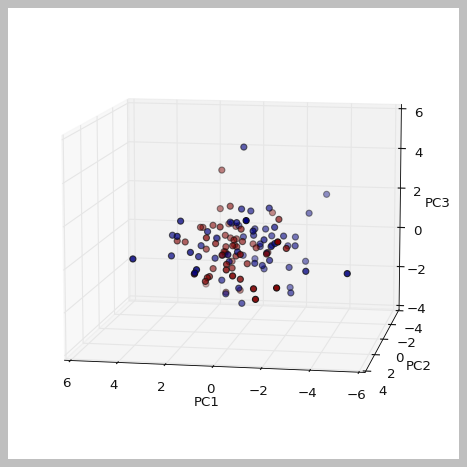

In [14]:
plt.style.use('classic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:, 0], X1[:, 1], X1[:, 2], c=df.Years, s=30)
ax.view_init(10, 100)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

# Podział na zbiory treningowy i testowy

In [15]:
seed = 7
test_size = 0.2
strategy = 'most_frequent'

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (96, 11)
Shape of X_test: (24, 11)


# Dummy classifier

In [16]:
dum = DummyClassifier(strategy=strategy)
dum = dum.fit(X_train, y_train)
score = dum.score(X_test, y_test)
print(f'Dummy Classifier Accuracy: {score * 100:.2f}')

Dummy Classifier Accuracy: 45.83


Text(0, 0.5, 'Frequency')

<Figure size 560x560 with 0 Axes>

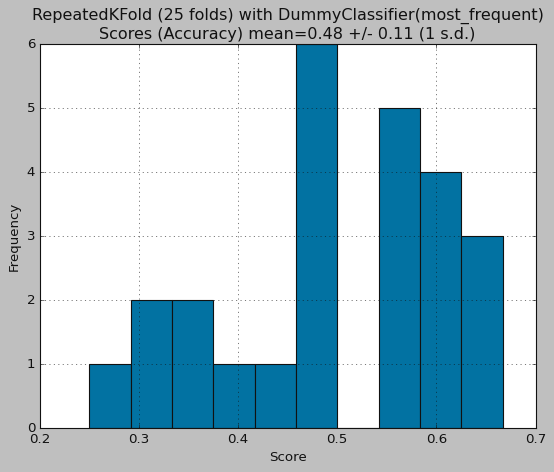

In [17]:
scores = cross_val_score(dum, X, Y,
       cv=RepeatedKFold(n_repeats=CV_N_REPEATS),
       scoring=None)
scores_dummy = scores.copy()

score_line = f'Scores (Accuracy) mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)'
plt.figure(figsize=(7, 7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f'RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n' + score_line)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')

# Funkcje pomocnicze do graficznego kreślenia drzewa decyzyjnego i macierzy pomyłek

In [18]:
def plot_tree_graph(model, columns, class_name):
       dot_data = export_graphviz(model, feature_names=columns, class_names=class_name)
       graph = graphviz.Source(dot_data)
       return graph

In [19]:
def confusion_mat(y_pred, y_test):
       plt.figure()
       sns.set(font_scale=1.5)
       cm = confusion_matrix(y_pred, y_test)
       sns.heatmap(cm, annot=True, fmt='g')
       plt.title('Confusion matrix', y=1.1)
       plt.ylabel('Actual label')
       plt.xlabel('Predicted label')
       plt.show()

# K-Nearest Neighbors

In [20]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f'Accuracy mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)')

Accuracy mean=0.71 +/- 0.08 (1 s.d.)


# Decision Tree classifier

In [21]:
dt = DecisionTreeClassifier(random_state=1, max_depth=2)
dt = dt.fit(X_train, y_train)

scores = cross_val_score(dt, X, Y,cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f'Accuracy mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)')

Accuracy mean=0.72 +/- 0.07 (1 s.d.)


# Bagging Classifier

In [22]:
bag = BaggingClassifier(n_estimators=100, oob_score=True)
bag = bag.fit(X_train, y_train)

scores = cross_val_score(bag, X, Y,cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f'Accuracy mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)')
print(f'Out of bag score: {bag.oob_score_ * 100:.2f}')

Accuracy mean=0.79 +/- 0.07 (1 s.d.)
Out of bag score: 78.12


# Random Forest

In [23]:
num_estimators=100
rf = RandomForestClassifier(n_estimators=num_estimators)
rf.fit(X_train, y_train)

scores = rf.score(X_test, y_test)
print(f'Accuracy of Random Forest {scores * 100}')

Accuracy of Random Forest 87.5


# Macierz pomyłek

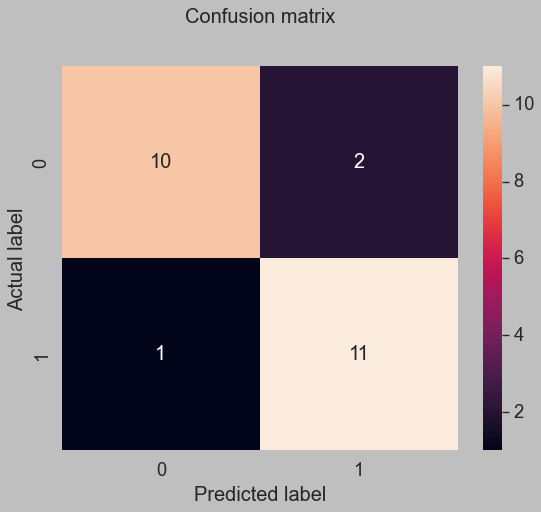

In [24]:
y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

# Ważność cech

In [25]:
feature_names = df.columns.values[:11]
show_weights(rf, feature_names=feature_names)

Weight,Feature
0.2449 ± 0.3599,SiO4Si
0.1129 ± 0.1866,NO3N
0.1111 ± 0.2104,NH4N
0.0939 ± 0.1734,DINtoDIP
0.0785 ± 0.1614,SRP
0.0775 ± 0.1537,DON
0.0688 ± 0.1601,TN/TP
0.0657 ± 0.1554,PP
0.0600 ± 0.1447,Fe
0.0494 ± 0.1247,DOP


# Wariancja w przewidywaniach

Text(0, 0.5, 'Frequency')

<Figure size 640x480 with 0 Axes>

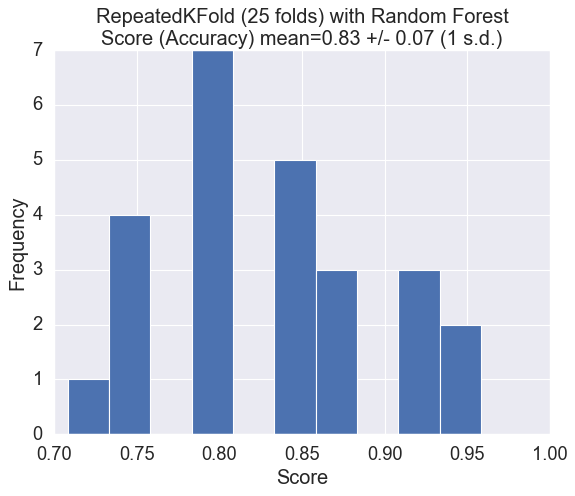

In [26]:
scores = cross_val_score(rf, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()

score_line = f'Score (Accuracy) mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)'

plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f'RepeatedKFold ({len(scores)} folds) with Random Forest\n' + score_line)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')

# Porównanie wydajności przewidywania klasyfikatora pozornego i lasu losowego

Text(0.5, 1.0, 'Dummy vs Random Forest Scores')

<Figure size 640x480 with 0 Axes>

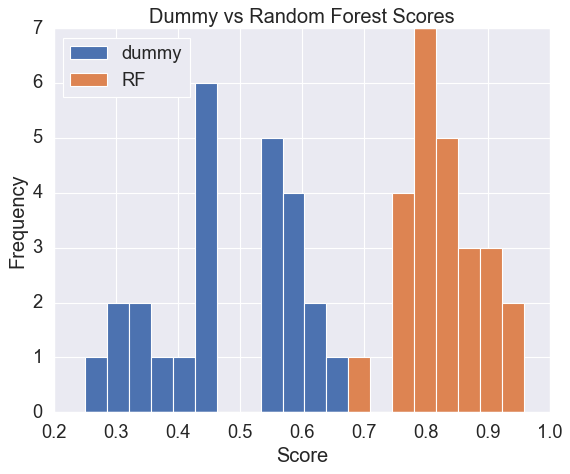

In [27]:
plt.figure()
fig, ax = plt.subplots()
df_dummy_est_scores = pd.DataFrame({'dummy': scores_dummy,'RF': scores_est})
df_dummy_est_scores.plot(kind='hist', ax=ax, bins=20)
ax.set_xlabel('Score')
ax.set_title('Dummy vs Random Forest Scores')

# Gradient Boosting classifier

In [28]:
params = {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500)

## Wykres odchylenia zestawu trenigowego i testowego względem liczby estymatorów

Text(0, 0.5, 'Log Loss')

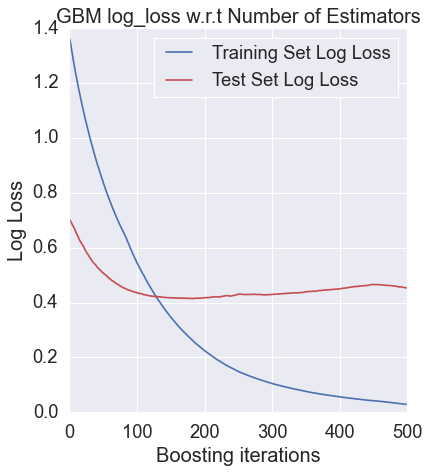

In [29]:
test_score = np.zeros((params["n_estimators"],),dtype=np.float64)

for i, y_pred in enumerate(gbm.staged_predict_proba(X_test)):
       test_score[i] = log_loss(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('GBM log_loss w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-', label='Training Set Log Loss')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Log Loss')
plt.legend(loc='best')
plt.xlabel('Boosting iterations')
plt.ylabel('Log Loss')

## Dokładność predykcji

In [30]:
params = {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)
gbm_score = accuracy_score(y_test, y_pred)
print(f'Accuracy of GBM Classifier: {gbm_score * 100:.2f}')

Accuracy of GBM Classifier: 91.67


# Macierz pomyłek

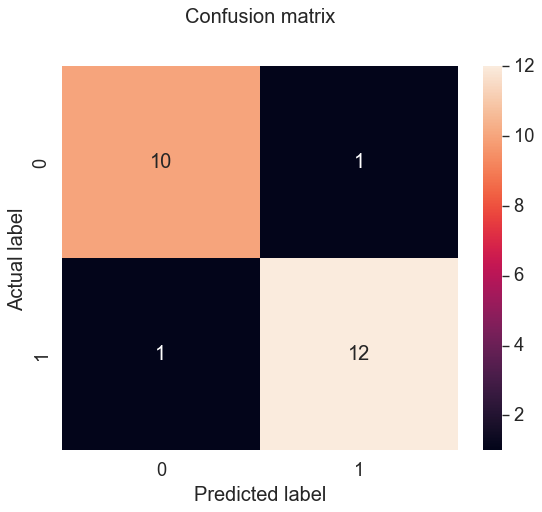

In [31]:
confusion_mat(y_pred, y_test)

## Ważność cech

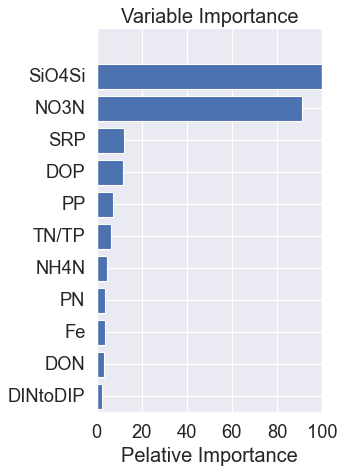

In [32]:
feature_importance = gbm.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Pelative Importance')
plt.title('Variable Importance')
plt.show()

# XgBoost

In [33]:
from xgboost import XGBClassifier, plot_importance

param = {'max_depth': 3, 'eta': 0.8, 'subsample': 1, 'objective': 'binary:logistic'}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

# Predykcje i macierz pomyłek

Accuracy of XGB Classifier: 75.00


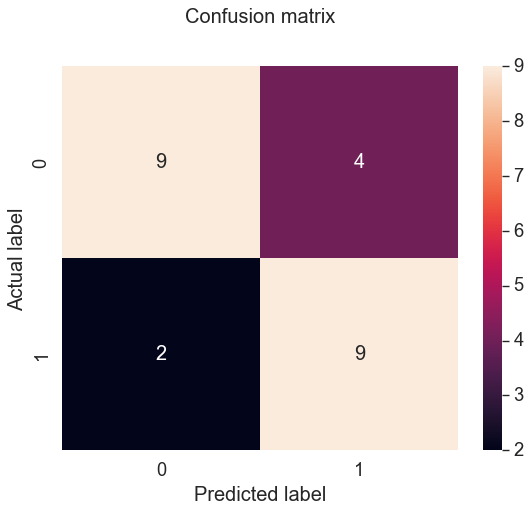

In [34]:
y_pred = xgb.predict(X_test)

xgb_score = accuracy_score(y_test, y_pred)
print(f'Accuracy of XGB Classifier: {xgb_score * 100:.2f}')
confusion_mat(y_pred, y_test)

# Ważność cech

<Figure size 640x480 with 0 Axes>

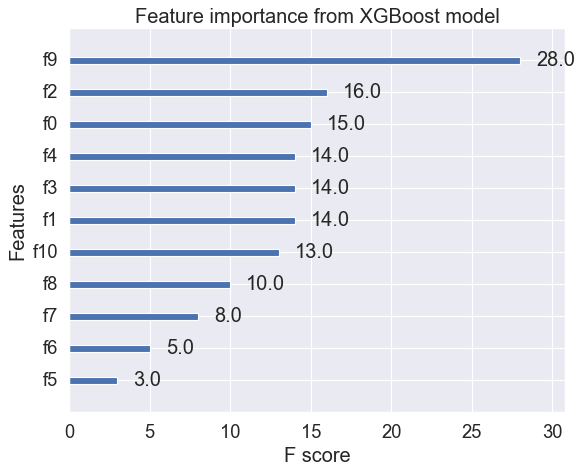

In [35]:
plt.figure()
plot_importance(xgb, title='Feature importance from XGBoost model')
plt.show()

# Voting classifier

In [36]:
from sklearn.ensemble import VotingClassifier

ensemble_knn_rf_xgb = VotingClassifier(estimators=[('KNN', knn), ('Random Forest', rf), ('XGBoost', xgb)], voting='hard')
ensemble_knn_rf_xgb.fit(X_train, y_train)

print(f'The ensembled model with all the 3 classifiers is: {ensemble_knn_rf_xgb.score(X_test, y_test)}')

The ensembled model with all the 3 classifiers is: 0.75


# Predykcje i macierz pomyłek

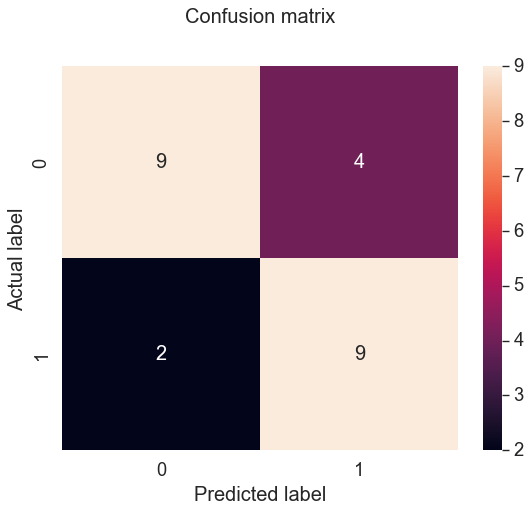

In [37]:
y_pred = ensemble_knn_rf_xgb.predict(X_test)
confusion_mat(y_pred, y_test)

# Stacking classifier

In [38]:
from mlxtend.classifier import StackingCVClassifier

sclf = StackingCVClassifier(classifiers=[knn, rf, xgb, gbm], meta_classifier=rf)
print('10-fold cross validation:\n')
for clf, label in zip([knn, rf, xgb, gbm, rf],
                      ['KNearest Neighbors',
                       'Random Forest',
                       'XGB',
                       'GBM',
                       'MetaClassifier'
                       ]):
       sclf_scores = model_selection.cross_val_score(
              clf, X, Y, cv=10, scoring='accuracy'
       )
       print(f'Accuracy: {sclf_scores.mean():.2f} (+/- {sclf_scores.std():.2f}) [{label}]')

10-fold cross validation:

Accuracy: 0.65 (+/- 0.15) [KNearest Neighbors]
Accuracy: 0.78 (+/- 0.15) [Random Forest]
Accuracy: 0.77 (+/- 0.17) [XGB]
Accuracy: 0.70 (+/- 0.12) [GBM]
Accuracy: 0.80 (+/- 0.15) [MetaClassifier]


# Wyniki algorytmów

In [39]:
models = []
models.append(('KNN', knn))
models.append(('DT', dt))
models.append(('RF', rf))
models.append(('GBM', gbm))
models.append(('XGB', xgb))
models.append(('Voting', ensemble_knn_rf_xgb))

results = []
names = []

for name, model in models:
       kfold = model_selection.StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
       cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
       results.append(cv_results)
       names.append(name)
       msg = f'{name}:{cv_results.mean()} ({cv_results.std()})'
       print(msg)

results.append(np.asarray(sclf_scores))
names.append('Stacking')

KNN:0.7666666666666667 (0.09718253158075502)
DT:0.6916666666666667 (0.09895285072531597)
RF:0.7999999999999999 (0.1)
GBM:0.7333333333333333 (0.10408329997330663)
XGB:0.7833333333333333 (0.1130388330520878)
Voting:0.7916666666666667 (0.08539125638299665)


## Porównanie algorytymów na wykresie pudełkowym

In [40]:
df_results = pd.DataFrame({
    'Model': np.repeat(names, [len(r) for r in results]),
    'Accuracy': np.concatenate(results)
})

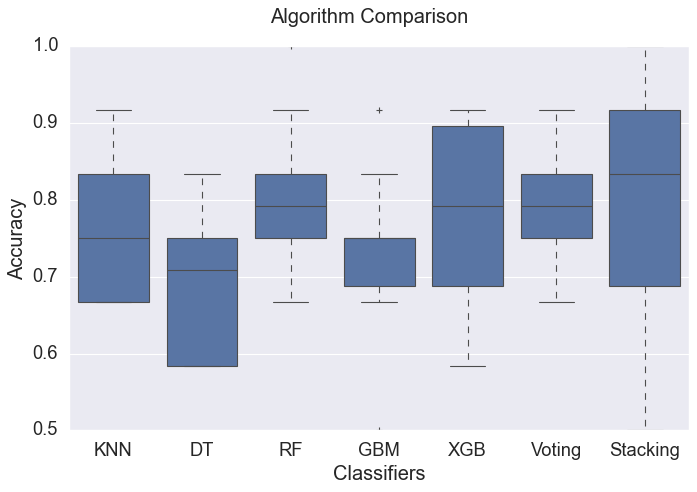

In [41]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = sns.boxplot(x='Model', y='Accuracy', data=df_results)
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

## XGB Classifier report

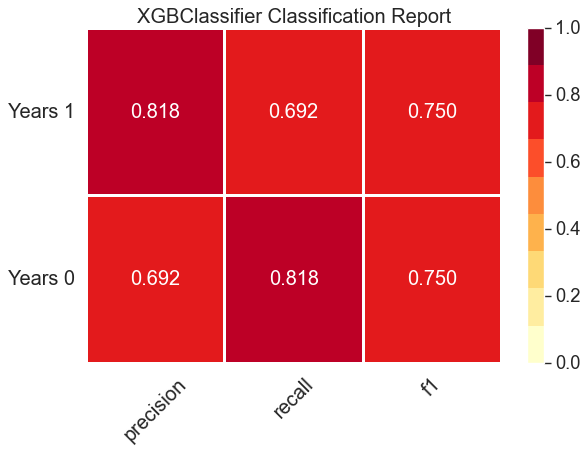

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [42]:
visualizer = ClassificationReport(xgb, classes=['Years 0', 'Years 1'])

visualizer.score(X_test, y_test)
visualizer.poof()

## Voting Classifier report

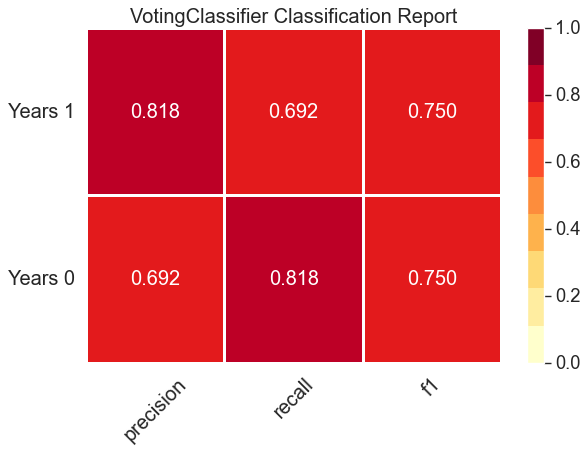

<Axes: title={'center': 'VotingClassifier Classification Report'}>

In [43]:
visualizer = ClassificationReport(ensemble_knn_rf_xgb, classes=['Years 0', 'Years 1'])

visualizer.score(X_test, y_test)
visualizer.poof()